In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.utils import to_scipy_sparse_matrix
import scipy
from torch_geometric.datasets import Planetoid, TUDataset, QM9
from scipy.sparse.csgraph import floyd_warshall, dijkstra
import seaborn as sns
import igraph
from models import TensorGNAN
from matplotlib.colors import LinearSegmentedColormap


In [5]:
MUTAGENITY_FEATURE_NAMES = list({
    0: 'C', 1: 'O', 2: 'Cl', 3: 'H', 4: 'N', 5: 'F', 6: 'Br',
    7: 'S', 8: 'P', 9: 'I', 10: 'Na', 11: 'K', 12: 'Li', 13: 'Ca'
}.values())

data_path = 'data'
dataset = TUDataset(root=data_path, name='Mutagenicity')
data = list(dataset)

NUM_FEATURES = data[0].x.size(-1)

# diameter for plotting
MAX_DISTANCE = 0
for g in data:
    igraph_graph = igraph.Graph(directed=False)
    igraph_graph.add_vertices(g.x.size(0))
    # igraph expects list of (u,v) tuples
    igraph_graph.add_edges(list(map(tuple, g.edge_index.T.cpu().numpy())))
    curr_max_distance = igraph_graph.diameter(directed=False)
    if curr_max_distance > MAX_DISTANCE:
        MAX_DISTANCE = curr_max_distance

In [ ]:
from models import GNAN


def load_model(checkpoint_path, task):
    if task == "mutagenicity":
        model = TensorGNAN(in_channels=15,
                            hidden_channels=64, 
                            n_layers=3,
                            out_channels=1, 
                            dropout=0.6, 
                            rho_per_feature=0,
                            normalize_rho=1, 
                            is_graph_task=True,
                            readout_n_layers=0)
    elif task == "cora":
        model = GNAN(in_channels=1434,
                    hidden_channels=64, 
                    num_layers=3,
                    out_channels=7, 
                    dropout=0.6, 
                    rho_per_feature=0,
                    normalize_rho=1)
    elif task == "ptc_mr":
        model = TensorGNAN(in_channels=19,
                            hidden_channels=64, 
                            n_layers=3,
                            out_channels=1, 
                            dropout=0.2, 
                            rho_per_feature=0,
                            normalize_rho=1, 
                            is_graph_task=True,
                            readout_n_layers=0)
        
    elif task == "citeseer":
        model = GNAN(in_channels=3704,
                    hidden_channels=64, 
                    num_layers=3,
                    out_channels=6, 
                    dropout=0.6, 
                    device='cpu',
                    rho_per_feature=0,
                    normalize_rho=1)
    else:
        raise NotImplementedError(f"load_model is not implemented for {task} yet")

    # Load weights
    state = torch.load(checkpoint_path, map_location='cpu')

    try:
        missing, unexpected = model.load_state_dict(state["state_dict"], strict=True)
    except:
        missing, unexpected = model.load_state_dict(state, strict=True)

    # print("Missing keys:", missing)
    # print("Unexpected keys:", unexpected)
    model.eval()
    return model



In [7]:
def plot_distance_function(model):
    # Plot rho in normalized distances (1 / (1 + d))
    x_ticks = [i for i in range(MAX_DISTANCE + 1)]
    y_input_values = torch.tensor([1/(1+i) for i in x_ticks], dtype=torch.float32).view(-1, 1)

    with torch.no_grad():
        m_y_values = model.rho(y_input_values).view(-1).cpu().numpy()
    # plot for distance function
    sns.set_style("whitegrid")
    plt.figure(figsize=(4, 2))

    x_ticks = [i for i in range(MAX_DISTANCE+1)]

    #remove the paddings in the beggining and end of the plot
    plt.xlim(-0.5, MAX_DISTANCE-0.5)
    plt.plot(x_ticks, m_y_values, marker='.', markersize=4)
    # plt.xticks(distance_ticks)
    plt.xlabel('Distance', size=9)
    plt.ylabel('Distance function output', size=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.show()

In [8]:
def plot_feature_function(model):
    f_scores = torch.zeros((NUM_FEATURES, ))
    for i in range(NUM_FEATURES):
        f_scores[i] = model.fs[i].forward(torch.tensor([1.0]).view(-1, 1)).detach().flatten()[0]

    # Make labels exactly num_features long
    if len(MUTAGENITY_FEATURE_NAMES) < NUM_FEATURES:
        feat_labels = MUTAGENITY_FEATURE_NAMES + [f'feat_{i}' for i in range(len(MUTAGENITY_FEATURE_NAMES), NUM_FEATURES)]
    else:
        feat_labels = MUTAGENITY_FEATURE_NAMES[:NUM_FEATURES]

    # plot a bar plot of the f_scores with the feature names
    plt.figure(figsize=(4, 2))
    plt.bar(feat_labels, f_scores.cpu().numpy())
    plt.xlabel('Feature (atom)', size=9)
    plt.ylabel('Feature function output', size=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

In [9]:
def plot_heatmap(model):
    x_ticks = [i for i in range(MAX_DISTANCE + 1)]

    y_input_values = torch.tensor([1/(1+i) for i in x_ticks], dtype=torch.float32).view(-1, 1)

    with torch.no_grad():
        m_y_values = model.rho(y_input_values).view(-1).cpu().numpy()
    f_scores = torch.zeros((NUM_FEATURES, ))
    for i in range(NUM_FEATURES):
        f_scores[i] = model.fs[i].forward(torch.tensor([1.0]).view(-1, 1)).detach().flatten()[0]
    
    if len(MUTAGENITY_FEATURE_NAMES) < NUM_FEATURES:
        feat_labels = MUTAGENITY_FEATURE_NAMES + [f'feat_{i}' for i in range(len(MUTAGENITY_FEATURE_NAMES), NUM_FEATURES)]
    else:
        feat_labels = MUTAGENITY_FEATURE_NAMES[:NUM_FEATURES]
        
    colors = ["red", "white", "green"]  # Red to white to green
    n_bins = 100  # Number of bins in the colormap
    cmap_name = "custom_colormap"
    # Create the colormap
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    plot_x = torch.tensor(np.arange(MAX_DISTANCE)).long()
    plot_y = torch.zeros((len(f_scores), 1))

    # heatmap z = f(feature) ⊗ rho(distance)
    z = np.outer(f_scores.cpu().numpy(), m_y_values)

    fig, ax= plt.subplots(figsize=(45, 15.5))
    sns.heatmap(
        z, annot=True, fmt=".2f",
        xticklabels=x_ticks, yticklabels=feat_labels,
        cmap=cmap, center=0, annot_kws={"fontsize":16}, cbar=False, ax=ax
    )
    cbar = plt.colorbar(ax.collections[0], ax=ax, use_gridspec=True, aspect=70)
    cbar.ax.set_position([0.75, 0.1, 2, 0.755])
    cbar.ax.tick_params(labelsize=20)
    plt.xticks(fontsize=20, weight='bold')
    plt.yticks(fontsize=20, weight='bold')
    plt.xlabel('Distance', size=30)
    plt.ylabel('Feature (atom)', size=30)
    plt.title('Mutagenicity, is mutagenic', size=20)
    plt.show()

In [10]:
def plot_all(checkpoint_path, task="mutagenicity"):
    model = load_model(checkpoint_path, task)
    plot_distance_function(model)
    plot_feature_function(model)
    plot_heatmap(model)

## Dropout 0.6

In [11]:
checkpoint_path = "dropout_0_6/174c151c-adb7-11f0-9233-9c63c0863466_mutagenicity_gnan_2732_best_val_loss.pt"
plot_all(checkpoint_path)

FileNotFoundError: [Errno 2] No such file or directory: 'dropout_0_6/174c151c-adb7-11f0-9233-9c63c0863466_mutagenicity_gnan_2732_best_val_loss.pt'

## Dropout 0.3

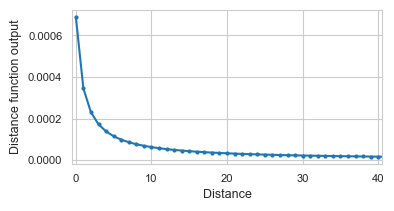

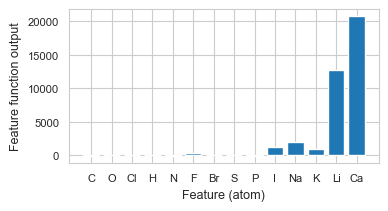

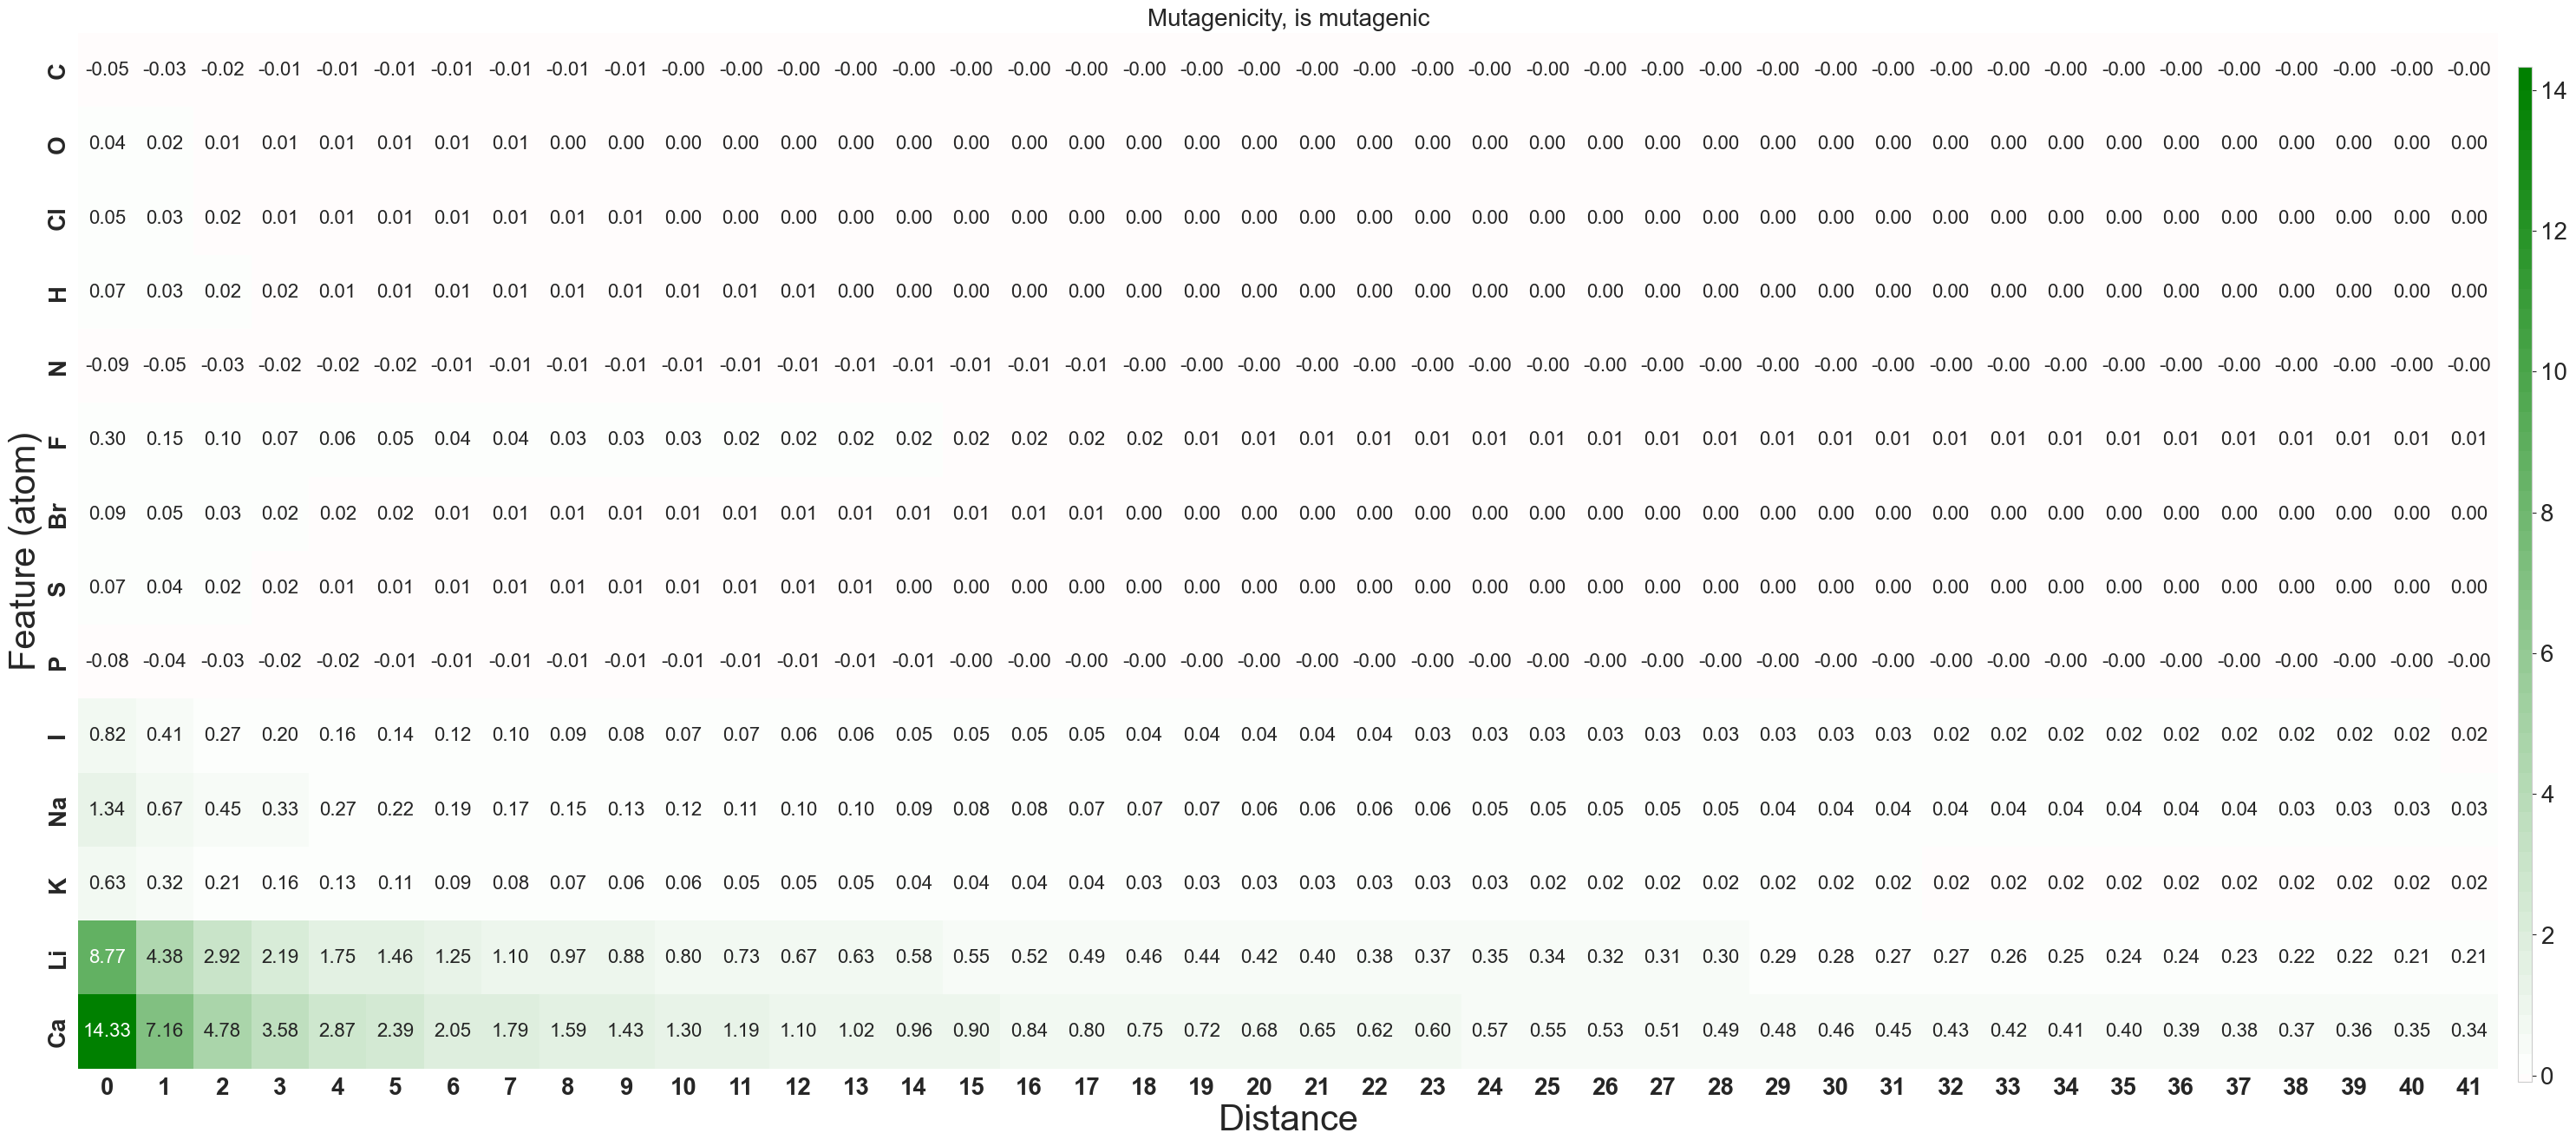

In [ ]:
checkpoint_path = "dropout_0_3/175a46f0-adb7-11f0-bba1-58a2e1283ab4_mutagenicity_gnan_2732_best_val_loss.pt"
plot_all(checkpoint_path)

## Dropout 0.0

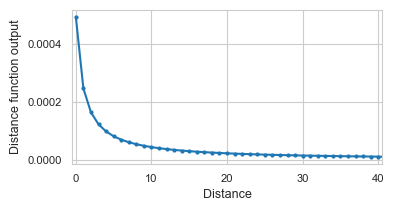

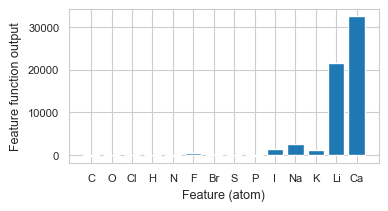

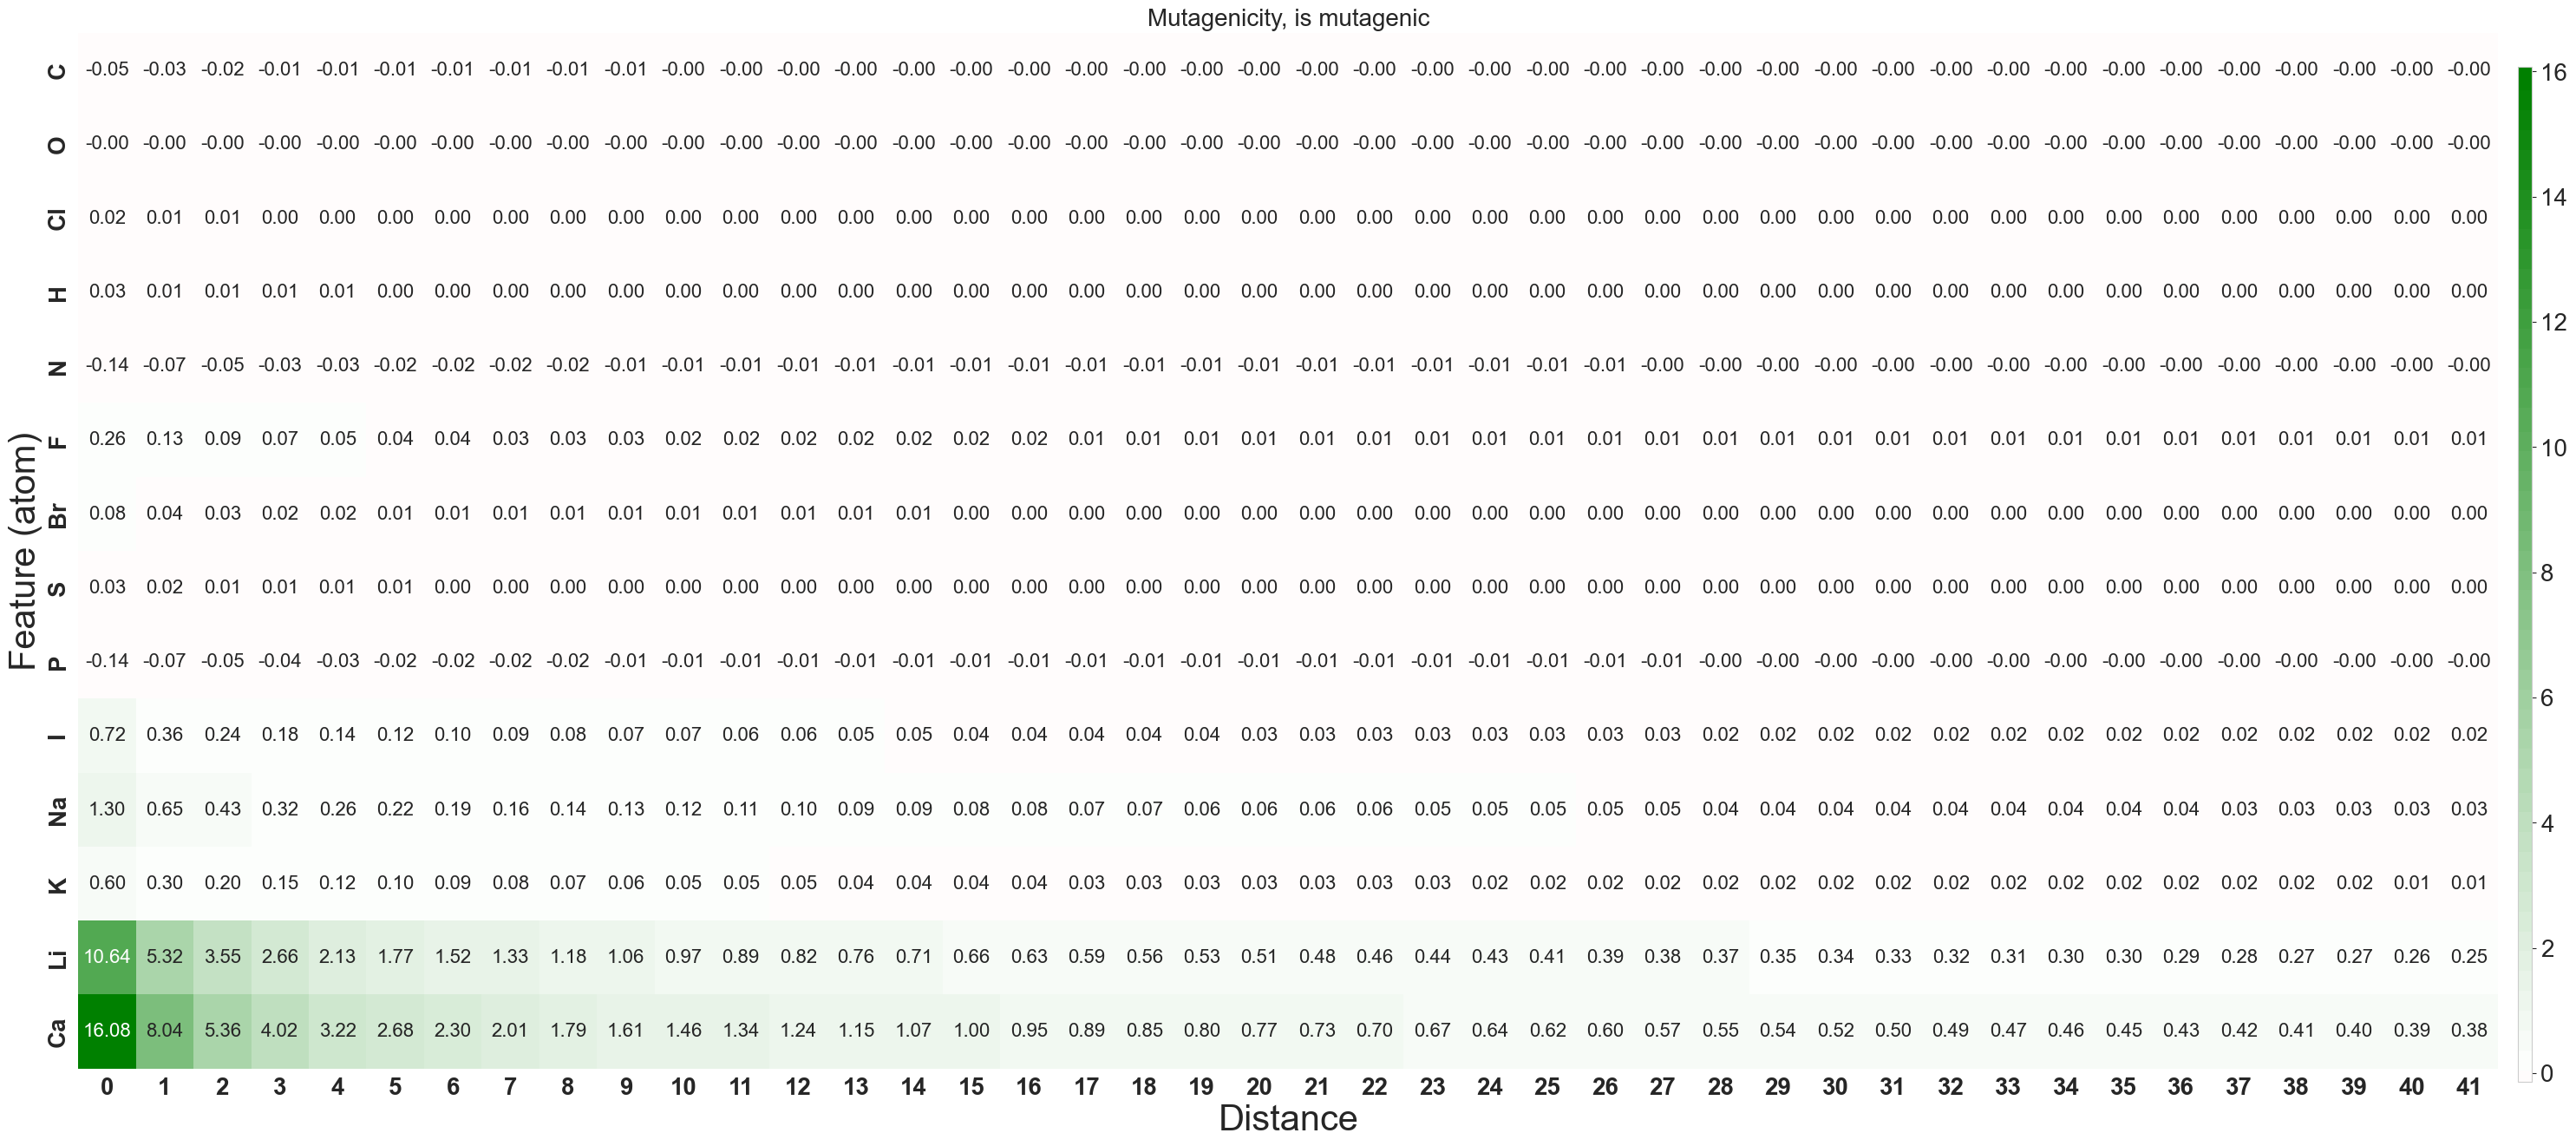

In [ ]:
checkpoint_path = "dropout_0_0/321c14e6-adb7-11f0-844e-9440c98edeec_mutagenicity_gnan_2732_best_val_loss.pt"
plot_all(checkpoint_path)

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [13]:
from trainer import get_accuracy


def test_epoch(model, dloader, device, label_index=0, val_mask=False, is_graph_task=True):
    with torch.no_grad():
        # all_probas = np.array([])
        # all_labels = np.array([])
        n_samples = 0
        running_acc : float = 0.0
        model.eval()
        for data in dloader:
            if len(data.y.shape) > 1:
                labels = data.y[:, label_index].view(-1, 1).flatten()
                labels = labels.float()
            else:
                labels = data.y.flatten()
            if -1 in labels:
                labels = (labels + 1) / 2
            inputs = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            non_zero_ids = None
            if model.__class__.__name__ == 'GNAM':
                if val_mask:
                    labels = labels[data.val_mask]
                    non_zero_ids = torch.nonzero(data.val_mask).flatten()
                else:
                    labels = labels[data.test_mask]
                    non_zero_ids = torch.nonzero(data.test_mask).flatten()

            # forward
            if non_zero_ids is not None:
                outputs = model.forward(inputs, non_zero_ids)
            else:
                outputs = model.forward(inputs)
                if not is_graph_task:
                    if val_mask:
                        outputs = outputs[data.val_mask]
                        labels = labels[data.val_mask]
                    else:
                        outputs = outputs[data.test_mask]
                        labels = labels[data.test_mask]
            n_samples += len(labels)
            # if outputs.dim() == 2 and outputs.shape[-1] == 1:
            #     loss = loss_fn(outputs.flatten(), labels.float())
            # else:
            #     loss = loss_fn(outputs, labels)
            # running_loss += loss.item()

            running_acc += get_accuracy(outputs, labels)
            # if compute_auc:
            #     probas = torch.sigmoid(outputs).view(-1)
            #     all_probas = np.concatenate((all_probas, probas.detach().cpu().numpy()))
            #     all_labels = np.concatenate((all_labels, labels.detach().cpu().numpy()))


        return running_acc / n_samples


In [14]:
import datasets


train_loader, val_loader, test_loader, num_features, num_classes, is_graph_task, is_regression, compute_auc = datasets.get_data(
        "mutagenicity", "processed_data")

Loading mutagenicity dataset
train labels: (array([0, 1]), array([1920, 1549]))
test labels: (array([0, 1]), array([481, 387]))
train labels: (array([0, 1]), array([1536, 1239]))
val labels: (array([0, 1]), array([384, 310]))


In [15]:
def test_model(checkpoint_path:str, task:str) -> float:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    _, _, test_loader, _, _, is_graph_task, _, _ = datasets.get_data(
        task, "processed_data")
    model = load_model(checkpoint_path, task)
    return test_epoch(model, test_loader, device, is_graph_task=is_graph_task)


In [16]:
task = "mutagenicity"

checkpoint_path = "dropout_0_0/321c14e6-adb7-11f0-844e-9440c98edeec_mutagenicity_gnan_2732_best_val_loss.pt"
print(f"Mutagenicity, dropout 0.0, best val loss: {test_model(checkpoint_path, task)}")
checkpoint_path = "dropout_0_0/321c14e6-adb7-11f0-844e-9440c98edeec_mutagenicity_gnan_2732_best_val_acc.pt"
print(f"Mutagenicity, dropout 0.0, best val acc: {test_model(checkpoint_path, task)}")


Loading mutagenicity dataset
train labels: (array([0, 1]), array([1920, 1549]))
test labels: (array([0, 1]), array([481, 387]))
train labels: (array([0, 1]), array([1536, 1239]))
val labels: (array([0, 1]), array([384, 310]))


FileNotFoundError: [Errno 2] No such file or directory: 'dropout_0_0/321c14e6-adb7-11f0-844e-9440c98edeec_mutagenicity_gnan_2732_best_val_loss.pt'

In [17]:
task = "mutagenicity"

checkpoint_path = "dropout_0_3/175a46f0-adb7-11f0-bba1-58a2e1283ab4_mutagenicity_gnan_2732_best_val_loss.pt"
print(f"Mutagenicity, dropout 0.3, best val loss: {test_model(checkpoint_path, task)}")
checkpoint_path = "dropout_0_3/175a46f0-adb7-11f0-bba1-58a2e1283ab4_mutagenicity_gnan_2732_best_val_loss.pt"
print(f"Mutagenicity, dropout 0.3, best val acc: {test_model(checkpoint_path, task)}")

Loading mutagenicity dataset
train labels: (array([0, 1]), array([1920, 1549]))
test labels: (array([0, 1]), array([481, 387]))
train labels: (array([0, 1]), array([1536, 1239]))
val labels: (array([0, 1]), array([384, 310]))


FileNotFoundError: [Errno 2] No such file or directory: 'dropout_0_3/175a46f0-adb7-11f0-bba1-58a2e1283ab4_mutagenicity_gnan_2732_best_val_loss.pt'

In [18]:
task = "mutagenicity"

checkpoint_path = "dropout_0_6/174c151c-adb7-11f0-9233-9c63c0863466_mutagenicity_gnan_2732_best_val_loss.pt"
print(f"Mutagenicity, dropout 0.6, best val loss: {test_model(checkpoint_path, task)}")
checkpoint_path = "dropout_0_6/174c151c-adb7-11f0-9233-9c63c0863466_mutagenicity_gnan_2732_best_val_acc.pt"
print(f"Mutagenicity, dropout 0.6, best val acc: {test_model(checkpoint_path, task)}")

Loading mutagenicity dataset
train labels: (array([0, 1]), array([1920, 1549]))
test labels: (array([0, 1]), array([481, 387]))
train labels: (array([0, 1]), array([1536, 1239]))
val labels: (array([0, 1]), array([384, 310]))


FileNotFoundError: [Errno 2] No such file or directory: 'dropout_0_6/174c151c-adb7-11f0-9233-9c63c0863466_mutagenicity_gnan_2732_best_val_loss.pt'

In [ ]:
task = "cora"

checkpoint_path = "cora/eadd9f3c-af73-11f0-a554-88e9a41023c1_cora_gnan_2732_best_val_loss.pt"
print(f"Cora, best val loss: {test_model(checkpoint_path, task)}")
checkpoint_path = "cora/eadd9f3c-af73-11f0-a554-88e9a41023c1_cora_gnan_2732_best_val_acc.pt"
print(f"Cora, best val acc: {test_model(checkpoint_path, task)}")

Cora, best val loss: 0.11599999666213989
Cora, best val acc: 0.3190000057220459


In [ ]:
task = "mutagenicity"

checkpoint_path = "models/dropout08_best_val_loss.pt"
print(f"Mutagenicity, dropout 0.8, best val loss: {test_model(checkpoint_path, task)}")
checkpoint_path = "models/dropout08_best_val_acc.pt"
print(f"Mutagenicity, dropout 0.8, best val acc: {test_model(checkpoint_path, task)}")

Loading mutagenicity dataset
train labels: (array([0, 1]), array([1920, 1549]))
test labels: (array([0, 1]), array([481, 387]))
train labels: (array([0, 1]), array([1536, 1239]))
val labels: (array([0, 1]), array([384, 310]))
Mutagenicity, dropout 0.8, best val loss: 0.6728110599078341
Loading mutagenicity dataset
train labels: (array([0, 1]), array([1920, 1549]))
test labels: (array([0, 1]), array([481, 387]))
train labels: (array([0, 1]), array([1536, 1239]))
val labels: (array([0, 1]), array([384, 310]))
Mutagenicity, dropout 0.8, best val acc: 0.673963133640553


In [ ]:
task = "mutagenicity"

checkpoint_path = "models/dropout09_best_val_loss.pt"
print(f"Mutagenicity, dropout 0.9, best val loss: {test_model(checkpoint_path, task)}")
checkpoint_path = "models/dropout09_best_val_acc.pt"
print(f"Mutagenicity, dropout 0.9, best val acc: {test_model(checkpoint_path, task)}")

Loading mutagenicity dataset
train labels: (array([0, 1]), array([1920, 1549]))
test labels: (array([0, 1]), array([481, 387]))
train labels: (array([0, 1]), array([1536, 1239]))
val labels: (array([0, 1]), array([384, 310]))
Mutagenicity, dropout 0.9, best val loss: 0.6785714285714286
Loading mutagenicity dataset
train labels: (array([0, 1]), array([1920, 1549]))
test labels: (array([0, 1]), array([481, 387]))
train labels: (array([0, 1]), array([1536, 1239]))
val labels: (array([0, 1]), array([384, 310]))
Mutagenicity, dropout 0.9, best val acc: 0.673963133640553


In [ ]:
task = "ptc_mr"
    
checkpoint_path = "models/a274d762-af8f-11f0-8f62-5e8654d3f871_ptc_mr_gnan_2732_best_val_loss.pt"
print(f"PTC_MR, dropout 0.9, best val loss: {test_model(checkpoint_path, task)}")
checkpoint_path = "models/a274d762-af8f-11f0-8f62-5e8654d3f871_ptc_mr_gnan_2732_best_val_acc.pt"
print(f"PTC_MR, dropout 0.9, best val acc: {test_model(checkpoint_path, task)}")

Loading ptc_mr dataset
train labels: (array([0, 1]), array([154, 121]))
test labels: (array([0, 1]), array([38, 31]))
train labels: (array([0, 1]), array([123,  97]))
val labels: (array([0, 1]), array([31, 24]))
PTC_MR, dropout 0.9, best val loss: 0.5942028985507246
Loading ptc_mr dataset
train labels: (array([0, 1]), array([154, 121]))
test labels: (array([0, 1]), array([38, 31]))
train labels: (array([0, 1]), array([123,  97]))
val labels: (array([0, 1]), array([31, 24]))
PTC_MR, dropout 0.9, best val acc: 0.5507246376811594


In [30]:
task = "citeseer"
    
checkpoint_path = "models/feca3bdc-afdb-11f0-8e24-5e8654d3f871_citeseer_gnan_2732_best_val_loss.pt"
print(f"CiteSeer, dropout 0.6, best val loss: {test_model(checkpoint_path, task)}")
checkpoint_path = "models/feca3bdc-afdb-11f0-8e24-5e8654d3f871_citeseer_gnan_2732_best_val_acc.pt"
print(f"CiteSeer, dropout 0.6, best val acc: {test_model(checkpoint_path, task)}")

Loading citeseer dataset


TypeError: GNAN.__init__() got an unexpected keyword argument 'normalize_m'